https://medium.com/grabngoinfo/hyperparameter-tuning-and-regularization-for-time-series-model-using-prophet-in-python-9791370a07dc

Import libraries

In [1]:
import pandas as pd
from prophet import Prophet
import itertools
from prophet.diagnostics import cross_validation, performance_metrics
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

/home/samuell/.local/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Importing plotly failed. Interactive plots will not work.


Load dataset and prepare df

In [2]:
file_path = "../data/parsed_dataset.csv"
date_column = "Date"
target_column = "Close"
df = pd.read_csv(file_path, parse_dates=True)
df = df[[date_column, target_column]]

df.set_index(date_column, inplace=True)
df = df.groupby(date_column).sum().reset_index()

df = df.dropna()
df.rename(columns={date_column: 'ds', target_column: 'y'}, inplace=True)
df['floor'] = 0
dates = df['ds'].values

Train test split

In [3]:
data_length = len(df)
train_split = 0.9
train = df.iloc[:int(data_length*train_split)]
test = df.iloc[int(data_length*train_split):]

Parameter tuning for order

In [4]:
# Initiate the model
baseline_model = Prophet()# Fit the model on the training dataset
baseline_model.fit(train)

10:44:13 - cmdstanpy - INFO - Chain [1] start processing
10:44:14 - cmdstanpy - INFO - Chain [1] done processing


Create Model

In [5]:
baseline_model_cv = cross_validation(model=baseline_model, initial='365 days', period='30 days', horizon = '30 days', parallel="processes")
baseline_model_cv.head()

Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.
10:44:16 - cmdstanpy - INFO - Chain [1] start processing
10:44:16 - cmdstanpy - INFO - Chain [1] start processing
10:44:16 - cmdstanpy - INFO - Chain [1] start processing
10:44:16 - cmdstanpy - INFO - Chain [1] start processing
10:44:16 - cmdstanpy - INFO - Chain [1] start processing
10:44:16 - cmdstanpy - INFO - Chain [1] start processing
10:44:16 - cmdstanpy - INFO - Chain [1] start processing
10:44:16 - cmdstanpy - INFO - Chain [1] start processing
10:44:16 - cmdstanpy - INFO - Chain [1] start processing
10:44:16 - cmdstanpy - INFO - Chain [1] done processing
10:44:16 - cmdstanpy - INFO - Chain [1] start processing
10:44:16 - cmdstanpy - INFO - Chain [1] start processing
10:44:16 - cmdstanpy - INFO - Chain [1] done processing
10:44:16 - cmdstanpy - INFO - Chain [1] done processing
10:44:16 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optim

,ds,yhat,yhat_lower,yhat_upper,y,cutoff
0,2015-10-06,230.519776,214.714518,247.192859,246.063004,2015-10-05
1,2015-10-07,230.172571,213.022335,247.297539,242.968994,2015-10-05
2,2015-10-08,230.317331,213.518512,248.163335,242.304001,2015-10-05
3,2015-10-09,230.971187,212.942748,248.853224,243.931000,2015-10-05
4,2015-10-10,229.039412,212.118672,245.862437,244.940994,2015-10-05


Plot the result

In [6]:
# Model performance metrics
baseline_model_p = performance_metrics(baseline_model_cv, rolling_window=1)
baseline_model_p.head()

,horizon,mse,rmse,mae,mape,mdape,smape,coverage
0,30 days,9.554355e+07,9774.638135,5646.276499,0.307077,0.240607,0.291767,0.267407


RMSE of the result

In [7]:
# Get the performance metric value
baseline_model_p['mape'].values[0]

0.30707682711236045

In [8]:
# Initiate the model
manual_model = Prophet(changepoint_range=0.9)# Fit the model on the training dataset
manual_model.fit(train)# Cross validation
manual_model_cv = cross_validation(manual_model, initial='365 days', period='30 days', horizon = '30 days', parallel="processes")# Model performance metrics
manual_model_p = performance_metrics(manual_model_cv, rolling_window=1)
manual_model_p['mape'].values[0]

10:44:33 - cmdstanpy - INFO - Chain [1] start processing
10:44:36 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.
10:44:37 - cmdstanpy - INFO - Chain [1] start processing
10:44:37 - cmdstanpy - INFO - Chain [1] done processing
10:44:37 - cmdstanpy - INFO - Chain [1] start processing
10:44:37 - cmdstanpy - INFO - Chain [1] start processing
10:44:37 - cmdstanpy - INFO - Chain [1] start processing
10:44:37 - cmdstanpy - INFO - Chain [1] done processing
10:44:37 - cmdstanpy - INFO - Chain [1] start processing
10:44:37 - cmdstanpy - INFO - Chain [1] start processing
10:44:37 - cmdstanpy - INFO - Chain [1] start processing
10:44:37 - cmdstanpy - INFO - Chain [1] start processing
10:44:37 - cmdstanpy - INFO - Chain [1] start processing
10:44:37 - cmdstanpy - INFO - Chain [1] done processing
10:44:37 - cmdstanpy - INFO - Chain [1] start processing
10:44:37 - cmdstanpy - INFO - Chain [1] start

0.2442109644215608

In [9]:
import numpy as np
# Set up parameter grid
param_grid = {  
    'changepoint_prior_scale': [0.001, 0.05, 0.08, 0.5],
    'seasonality_prior_scale': [0.01, 1, 5, 10, 12],
    'seasonality_mode': ['additive', 'multiplicative']
}# Generate all combinations of parameters
all_params = [dict(zip(param_grid.keys(), v)) for v in itertools.product(*param_grid.values())]# Create a list to store MAPE values for each combination
mapes = [] # Use cross validation to evaluate all parameters
for params in all_params:
    # Fit a model using one parameter combination
    m = Prophet(**params, changepoint_range=0.9).fit(train)  
    # Cross-validation
    df_cv = cross_validation(m, initial='365 days', period='30 days', horizon = '30 days', parallel="processes")
    # Model performance
    df_p = performance_metrics(df_cv, rolling_window=1)
    # Save model performance metrics
    mapes.append(df_p['mape'].values[0])
    
# Tuning results
tuning_results = pd.DataFrame(all_params)
tuning_results['mape'] = mapes# Find the best parameters
best_params = all_params[np.argmin(mapes)]
print(best_params)

10:44:58 - cmdstanpy - INFO - Chain [1] start processing
10:44:58 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.
10:45:00 - cmdstanpy - INFO - Chain [1] start processing
10:45:00 - cmdstanpy - INFO - Chain [1] start processing
10:45:00 - cmdstanpy - INFO - Chain [1] start processing
10:45:00 - cmdstanpy - INFO - Chain [1] start processing
10:45:00 - cmdstanpy - INFO - Chain [1] done processing
10:45:00 - cmdstanpy - INFO - Chain [1] done processing
10:45:00 - cmdstanpy - INFO - Chain [1] done processing
10:45:00 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
10:45:00 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
Optimization terminated abnormally. Falling back to Newton.
10:45:00 - cmdstanpy - INFO - Chain [1] done processing
10:45:00 - cmdstanp

{'changepoint_prior_scale': 0.5, 'seasonality_prior_scale': 1, 'seasonality_mode': 'additive'}


In [10]:
# Fit the model using the best parameters
auto_model = Prophet(changepoint_prior_scale=best_params['changepoint_prior_scale'], 
                     seasonality_prior_scale=best_params['seasonality_prior_scale'], 
                     seasonality_mode=best_params['seasonality_mode'], changepoint_range=0.9)# Fit the model on the training dataset
auto_model.fit(train)# Cross validation


pred = auto_model.predict(test[['ds']])
auto_model_cv = cross_validation(auto_model, initial='365 days', period='30 days', horizon = '30 days', parallel="processes")# Model performance metrics
auto_model_p = performance_metrics(auto_model_cv, rolling_window=1)
auto_model_p

11:05:21 - cmdstanpy - INFO - Chain [1] start processing
11:05:24 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.
11:05:26 - cmdstanpy - INFO - Chain [1] start processing
11:05:26 - cmdstanpy - INFO - Chain [1] start processing
11:05:26 - cmdstanpy - INFO - Chain [1] start processing
11:05:26 - cmdstanpy - INFO - Chain [1] start processing
11:05:26 - cmdstanpy - INFO - Chain [1] start processing
11:05:26 - cmdstanpy - INFO - Chain [1] start processing
11:05:26 - cmdstanpy - INFO - Chain [1] start processing
11:05:26 - cmdstanpy - INFO - Chain [1] start processing
11:05:26 - cmdstanpy - INFO - Chain [1] start processing
11:05:26 - cmdstanpy - INFO - Chain [1] start processing
11:05:26 - cmdstanpy - INFO - Chain [1] start processing
11:05:26 - cmdstanpy - INFO - Chain [1] done processing
11:05:26 - cmdstanpy - INFO - Chain [1] start processing
11:05:26 - cmdstanpy - INFO - Chain [1] sta

,horizon,mse,rmse,mae,mape,mdape,smape,coverage
0,30 days,3.092629e+07,5561.141274,3062.724003,0.191637,0.146118,0.19008,0.312963


In [11]:
pred

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2023-02-26,15381.055546,14613.679926,23240.112449,15381.055546,15381.055546,3529.803699,3529.803699,3529.803699,-7.225645,-7.225645,-7.225645,3537.029344,3537.029344,3537.029344,0.0,0.0,0.0,18910.859245
1,2023-02-27,15330.816951,14605.082732,23194.340143,15330.816951,15330.816951,3516.285853,3516.285853,3516.285853,7.099883,7.099883,7.099883,3509.185970,3509.185970,3509.185970,0.0,0.0,0.0,18847.102804
2,2023-02-28,15280.578357,14525.042471,23239.360151,15280.578357,15280.578357,3462.425561,3462.425561,3462.425561,-13.682988,-13.682988,-13.682988,3476.108548,3476.108548,3476.108548,0.0,0.0,0.0,18743.003918
3,2023-03-01,15230.339762,14864.345902,23232.049897,15230.339762,15230.339762,3464.910595,3464.910595,3464.910595,24.942836,24.942836,24.942836,3439.967759,3439.967759,3439.967759,0.0,0.0,0.0,18695.250357
4,2023-03-02,15180.101168,14636.495117,23047.461111,15180.101168,15180.101168,3383.556677,3383.556677,3383.556677,-19.383268,-19.383268,-19.383268,3402.939945,3402.939945,3402.939945,0.0,0.0,0.0,18563.657845
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
337,2024-01-29,-1549.350756,-51149.482599,48096.569500,-51127.517995,46686.895705,422.613644,422.613644,422.613644,7.099883,7.099883,7.099883,415.513761,415.513761,415.513761,0.0,0.0,0.0,-1126.737112
338,2024-01-30,-1599.589350,-51218.791267,48606.277935,-51462.596453,46977.277818,479.142345,479.142345,479.142345,-13.682988,-13.682988,-13.682988,492.825333,492.825333,492.825333,0.0,0.0,0.0,-1120.447005
339,2024-01-31,-1649.827945,-51107.845397,47341.403024,-51797.674911,47267.659931,612.764706,612.764706,612.764706,24.942836,24.942836,24.942836,587.821870,587.821870,587.821870,0.0,0.0,0.0,-1037.063238
340,2024-02-01,-1700.066539,-51330.944540,46128.238487,-52132.753369,47558.042043,680.365452,680.365452,680.365452,-19.383268,-19.383268,-19.383268,699.748720,699.748720,699.748720,0.0,0.0,0.0,-1019.701087


In [12]:
from metrics import print_evaluation_metrics
non_zero = []
import sys
 
for i in pred['yhat']:
    if i == 0:
        non_zero.append(i+sys.float_info.min)
    else:
        non_zero.append(i)
print_evaluation_metrics(non_zero, test['y'])

Evaluation Metrics:
MSE: 743910741.06
RMSE: 27274.73
MAE: 24768.10
MAPE: 75.77
SMAPE: 132.89


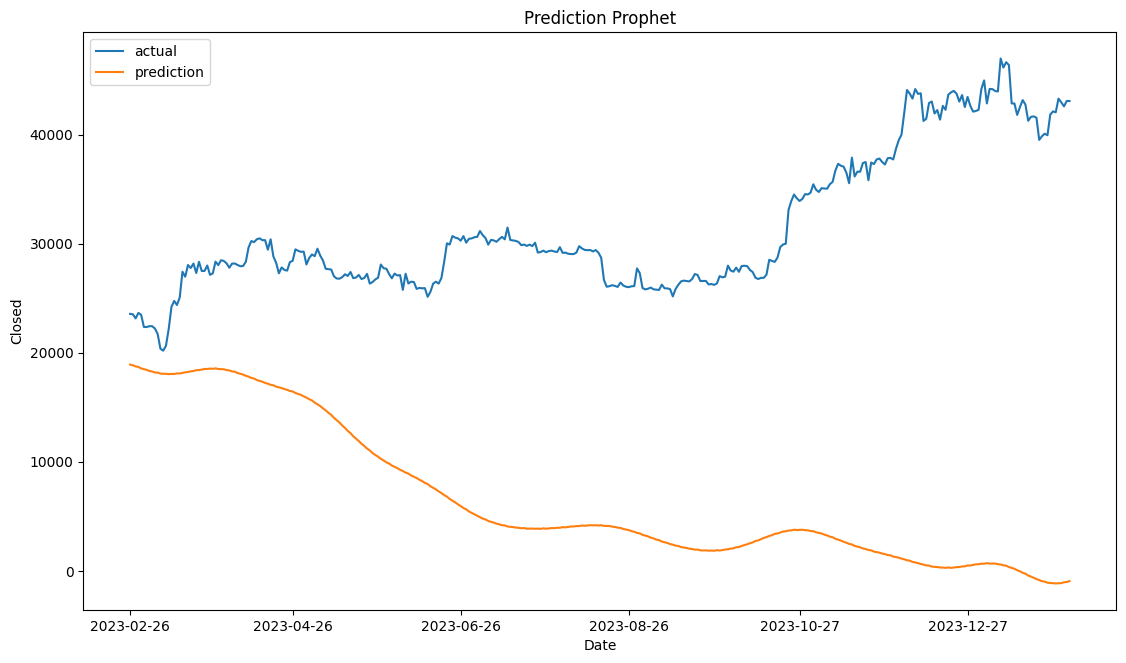

In [13]:
fig, ax = plt.subplots(1, 1, figsize=(1280 / 96, 720 / 96))
ax.plot(test['ds'], test['y'].values, label="actual")
ax.plot(test['ds'], pred['yhat'], label="prediction")
ax.set_title("Prediction Prophet")
ax.set_ylabel("Closed")
ax.set_xlabel(date_column)
ax.legend()
ax.xaxis.set_major_locator(mdates.AutoDateLocator())
plt.show()

In [14]:
# Create a copy of the data
data_log = df.copy()# Create the log scale data by taking the natual log of the stock prices.
data_log['y_log'] = np.log(df['y'])
data_log = data_log.drop('y', axis=1).rename(columns={'y_log': 'y'})
data_log.head()

,ds,floor,y
0,2014-09-24,0,6.047857
1,2014-09-25,0,6.019989
2,2014-09-26,0,6.002466
3,2014-09-27,0,5.990264
4,2014-09-28,0,5.932725


In [16]:
# Parameter grid
param_grid = {  
    'changepoint_prior_scale': [0.001, 0.05, 0.08, 0.5],
    'seasonality_prior_scale': [0.01, 1.0, 5, 10, 12],
    'seasonality_mode': ['additive', 'multiplicative']
}# Generate all combinations of parameters
all_params = [dict(zip(param_grid.keys(), v)) for v in itertools.product(*param_grid.values())]
mapes = []  # Store the MAPEs for each params here# Use cross validation to evaluate all parameters
for params in all_params:
    # Fit a model using one parameter combination
    m = Prophet(**params).fit(data_log)
    # Cross-validation
    df_cv = cross_validation(m, initial='365 days', period='30 days', horizon = '30 days', parallel="processes")
    # Model performance
    df_p = performance_metrics(df_cv, rolling_window=1)
    # Save model performance metrics
    print(df_p)
    mapes.append(df_p['smape'].values[0])# Tuning results
best_params = all_params[np.argmin(mapes)]# Best parameters
print(best_params)# Train model using best parameters
auto_model_log = Prophet(changepoint_prior_scale=best_params['changepoint_prior_scale'], 
                     seasonality_prior_scale=best_params['seasonality_prior_scale'], 
                     seasonality_mode=best_params['seasonality_mode'])# Fit the model on the training dataset
auto_model_log.fit(data_log)# Cross validation
auto_model_log_cv = cross_validation(auto_model_log, initial='365 days', period='30 days', horizon = '30 days', parallel="processes")# Model performance metrics
auto_model_log_p = performance_metrics(auto_model_log_cv, rolling_window=1)
auto_model_log_p

14:04:44 - cmdstanpy - INFO - Chain [1] start processing
14:04:44 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.
14:04:47 - cmdstanpy - INFO - Chain [1] start processing
14:04:47 - cmdstanpy - INFO - Chain [1] start processing
14:04:47 - cmdstanpy - INFO - Chain [1] start processing
14:04:47 - cmdstanpy - INFO - Chain [1] done processing
14:04:47 - cmdstanpy - INFO - Chain [1] start processing
14:04:47 - cmdstanpy - INFO - Chain [1] start processing
14:04:47 - cmdstanpy - INFO - Chain [1] start processing
14:04:47 - cmdstanpy - INFO - Chain [1] start processing
14:04:47 - cmdstanpy - INFO - Chain [1] start processing
14:04:47 - cmdstanpy - INFO - Chain [1] start processing
14:04:47 - cmdstanpy - INFO - Chain [1] start processing
14:04:47 - cmdstanpy - INFO - Chain [1] done processing
14:04:47 - cmdstanpy - INFO - Chain [1] done processing
14:04:47 - cmdstanpy - INFO - Chain [1] start

  horizon       mse      rmse       mae      mape     mdape     smape  \
0 30 days  0.415887  0.644893  0.524916  0.058738  0.049433  0.057472   

   coverage  
0  0.464356  


14:05:01 - cmdstanpy - INFO - Chain [1] start processing
14:05:01 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.
14:05:03 - cmdstanpy - INFO - Chain [1] start processing
14:05:03 - cmdstanpy - INFO - Chain [1] start processing
14:05:03 - cmdstanpy - INFO - Chain [1] done processing
14:05:03 - cmdstanpy - INFO - Chain [1] start processing
14:05:03 - cmdstanpy - INFO - Chain [1] done processing
14:05:03 - cmdstanpy - INFO - Chain [1] start processing
14:05:03 - cmdstanpy - INFO - Chain [1] start processing
14:05:04 - cmdstanpy - INFO - Chain [1] start processing
14:05:04 - cmdstanpy - INFO - Chain [1] start processing
14:05:04 - cmdstanpy - INFO - Chain [1] done processing
14:05:04 - cmdstanpy - INFO - Chain [1] done processing
14:05:04 - cmdstanpy - INFO - Chain [1] done processing
14:05:04 - cmdstanpy - INFO - Chain [1] done processing
14:05:04 - cmdstanpy - INFO - Chain [1] start pr

  horizon      mse      rmse       mae      mape     mdape    smape  coverage
0 30 days  0.46126  0.679162  0.555102  0.062226  0.054145  0.06081  0.447525


14:05:16 - cmdstanpy - INFO - Chain [1] start processing
14:05:17 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.
14:05:19 - cmdstanpy - INFO - Chain [1] start processing
14:05:19 - cmdstanpy - INFO - Chain [1] start processing
14:05:19 - cmdstanpy - INFO - Chain [1] done processing
14:05:19 - cmdstanpy - INFO - Chain [1] done processing
14:05:19 - cmdstanpy - INFO - Chain [1] start processing
14:05:19 - cmdstanpy - INFO - Chain [1] start processing
14:05:19 - cmdstanpy - INFO - Chain [1] done processing
14:05:19 - cmdstanpy - INFO - Chain [1] start processing
14:05:19 - cmdstanpy - INFO - Chain [1] start processing
14:05:19 - cmdstanpy - INFO - Chain [1] start processing
14:05:20 - cmdstanpy - INFO - Chain [1] start processing
14:05:20 - cmdstanpy - INFO - Chain [1] done processing
14:05:20 - cmdstanpy - INFO - Chain [1] start processing
14:05:20 - cmdstanpy - INFO - Chain [1] start 

  horizon       mse      rmse     mae      mape     mdape     smape  coverage
0 30 days  0.419853  0.647961  0.5277  0.059222  0.050919  0.057942  0.449835


14:05:38 - cmdstanpy - INFO - Chain [1] start processing
14:05:39 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.
14:05:43 - cmdstanpy - INFO - Chain [1] start processing
14:05:43 - cmdstanpy - INFO - Chain [1] start processing
14:05:43 - cmdstanpy - INFO - Chain [1] start processing
14:05:43 - cmdstanpy - INFO - Chain [1] start processing
14:05:43 - cmdstanpy - INFO - Chain [1] done processing
14:05:43 - cmdstanpy - INFO - Chain [1] start processing
14:05:43 - cmdstanpy - INFO - Chain [1] start processing
14:05:43 - cmdstanpy - INFO - Chain [1] start processing
14:05:43 - cmdstanpy - INFO - Chain [1] done processing
14:05:43 - cmdstanpy - INFO - Chain [1] start processing
14:05:43 - cmdstanpy - INFO - Chain [1] start processing
14:05:43 - cmdstanpy - INFO - Chain [1] start processing
14:05:43 - cmdstanpy - INFO - Chain [1] start processing
14:05:43 - cmdstanpy - INFO - Chain [1] star

  horizon       mse     rmse       mae     mape     mdape     smape  coverage
0 30 days  0.467788  0.68395  0.557755  0.06255  0.053055  0.061165  0.445875


14:06:02 - cmdstanpy - INFO - Chain [1] start processing
14:06:03 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.
14:06:05 - cmdstanpy - INFO - Chain [1] start processing
14:06:05 - cmdstanpy - INFO - Chain [1] done processing
14:06:05 - cmdstanpy - INFO - Chain [1] start processing
14:06:05 - cmdstanpy - INFO - Chain [1] start processing
14:06:05 - cmdstanpy - INFO - Chain [1] start processing
14:06:05 - cmdstanpy - INFO - Chain [1] start processing
14:06:05 - cmdstanpy - INFO - Chain [1] start processing
14:06:05 - cmdstanpy - INFO - Chain [1] start processing
14:06:05 - cmdstanpy - INFO - Chain [1] start processing
14:06:05 - cmdstanpy - INFO - Chain [1] start processing
14:06:05 - cmdstanpy - INFO - Chain [1] start processing
14:06:05 - cmdstanpy - INFO - Chain [1] done processing
14:06:05 - cmdstanpy - INFO - Chain [1] done processing
14:06:05 - cmdstanpy - INFO - Chain [1] done 

  horizon       mse      rmse     mae      mape     mdape     smape  coverage
0 30 days  0.419794  0.647915  0.5278  0.059248  0.050645  0.057974  0.456766


14:06:23 - cmdstanpy - INFO - Chain [1] start processing
14:06:24 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.
14:06:27 - cmdstanpy - INFO - Chain [1] start processing
14:06:27 - cmdstanpy - INFO - Chain [1] start processing
14:06:27 - cmdstanpy - INFO - Chain [1] done processing
14:06:27 - cmdstanpy - INFO - Chain [1] start processing
14:06:27 - cmdstanpy - INFO - Chain [1] start processing
14:06:27 - cmdstanpy - INFO - Chain [1] done processing
14:06:27 - cmdstanpy - INFO - Chain [1] start processing
14:06:27 - cmdstanpy - INFO - Chain [1] start processing
14:06:27 - cmdstanpy - INFO - Chain [1] start processing
14:06:27 - cmdstanpy - INFO - Chain [1] done processing
14:06:27 - cmdstanpy - INFO - Chain [1] start processing
14:06:27 - cmdstanpy - INFO - Chain [1] done processing
14:06:27 - cmdstanpy - INFO - Chain [1] start processing
14:06:27 - cmdstanpy - INFO - Chain [1] done p

  horizon       mse      rmse       mae      mape     mdape     smape  \
0 30 days  0.468001  0.684106  0.559128  0.062689  0.053216  0.061293   

   coverage  
0  0.445545  


14:06:43 - cmdstanpy - INFO - Chain [1] start processing
14:06:44 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.
14:06:46 - cmdstanpy - INFO - Chain [1] start processing
14:06:46 - cmdstanpy - INFO - Chain [1] start processing
14:06:46 - cmdstanpy - INFO - Chain [1] start processing
14:06:46 - cmdstanpy - INFO - Chain [1] start processing
14:06:46 - cmdstanpy - INFO - Chain [1] start processing
14:06:46 - cmdstanpy - INFO - Chain [1] start processing
14:06:46 - cmdstanpy - INFO - Chain [1] start processing
14:06:46 - cmdstanpy - INFO - Chain [1] start processing
14:06:46 - cmdstanpy - INFO - Chain [1] start processing
14:06:46 - cmdstanpy - INFO - Chain [1] start processing
14:06:46 - cmdstanpy - INFO - Chain [1] start processing
14:06:46 - cmdstanpy - INFO - Chain [1] done processing
14:06:46 - cmdstanpy - INFO - Chain [1] done processing
14:06:46 - cmdstanpy - INFO - Chain [1] done

  horizon       mse      rmse       mae     mape     mdape     smape  coverage
0 30 days  0.417113  0.645843  0.525274  0.05896  0.050714  0.057677  0.455116


14:07:01 - cmdstanpy - INFO - Chain [1] start processing
14:07:02 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.
14:07:03 - cmdstanpy - INFO - Chain [1] start processing
14:07:04 - cmdstanpy - INFO - Chain [1] start processing
14:07:04 - cmdstanpy - INFO - Chain [1] start processing
14:07:04 - cmdstanpy - INFO - Chain [1] done processing
14:07:04 - cmdstanpy - INFO - Chain [1] start processing
14:07:04 - cmdstanpy - INFO - Chain [1] start processing
14:07:04 - cmdstanpy - INFO - Chain [1] start processing
14:07:04 - cmdstanpy - INFO - Chain [1] done processing
14:07:04 - cmdstanpy - INFO - Chain [1] start processing
14:07:04 - cmdstanpy - INFO - Chain [1] start processing
14:07:04 - cmdstanpy - INFO - Chain [1] done processing
14:07:04 - cmdstanpy - INFO - Chain [1] start processing
14:07:04 - cmdstanpy - INFO - Chain [1] start processing
14:07:04 - cmdstanpy - INFO - Chain [1] start

  horizon       mse      rmse       mae      mape     mdape     smape  \
0 30 days  0.467121  0.683463  0.559196  0.062638  0.053316  0.061225   

   coverage  
0  0.444884  


14:07:18 - cmdstanpy - INFO - Chain [1] start processing
14:07:18 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.
14:07:20 - cmdstanpy - INFO - Chain [1] start processing
14:07:20 - cmdstanpy - INFO - Chain [1] start processing
14:07:20 - cmdstanpy - INFO - Chain [1] start processing
14:07:20 - cmdstanpy - INFO - Chain [1] start processing
14:07:20 - cmdstanpy - INFO - Chain [1] done processing
14:07:20 - cmdstanpy - INFO - Chain [1] done processing
14:07:20 - cmdstanpy - INFO - Chain [1] start processing
14:07:20 - cmdstanpy - INFO - Chain [1] done processing
14:07:20 - cmdstanpy - INFO - Chain [1] start processing
14:07:20 - cmdstanpy - INFO - Chain [1] start processing
14:07:21 - cmdstanpy - INFO - Chain [1] done processing
14:07:21 - cmdstanpy - INFO - Chain [1] start processing
14:07:21 - cmdstanpy - INFO - Chain [1] start processing
14:07:21 - cmdstanpy - INFO - Chain [1] start 

  horizon       mse      rmse      mae      mape     mdape     smape  coverage
0 30 days  0.417644  0.646254  0.52551  0.058994  0.050971  0.057709  0.457096


14:07:34 - cmdstanpy - INFO - Chain [1] start processing
14:07:35 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.
14:07:36 - cmdstanpy - INFO - Chain [1] start processing
14:07:36 - cmdstanpy - INFO - Chain [1] start processing
14:07:36 - cmdstanpy - INFO - Chain [1] done processing
14:07:37 - cmdstanpy - INFO - Chain [1] start processing
14:07:37 - cmdstanpy - INFO - Chain [1] start processing
14:07:37 - cmdstanpy - INFO - Chain [1] start processing
14:07:37 - cmdstanpy - INFO - Chain [1] done processing
14:07:37 - cmdstanpy - INFO - Chain [1] start processing
14:07:37 - cmdstanpy - INFO - Chain [1] start processing
14:07:37 - cmdstanpy - INFO - Chain [1] done processing
14:07:37 - cmdstanpy - INFO - Chain [1] done processing
14:07:37 - cmdstanpy - INFO - Chain [1] start processing
14:07:37 - cmdstanpy - INFO - Chain [1] done processing
14:07:37 - cmdstanpy - INFO - Chain [1] done pr

  horizon       mse      rmse       mae      mape     mdape     smape  \
0 30 days  0.471201  0.686441  0.561957  0.062981  0.053426  0.061582   

   coverage  
0  0.448515  


14:07:51 - cmdstanpy - INFO - Chain [1] start processing
14:07:55 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.
14:07:57 - cmdstanpy - INFO - Chain [1] start processing
14:07:57 - cmdstanpy - INFO - Chain [1] start processing
14:07:57 - cmdstanpy - INFO - Chain [1] start processing
14:07:57 - cmdstanpy - INFO - Chain [1] start processing
14:07:57 - cmdstanpy - INFO - Chain [1] start processing
14:07:57 - cmdstanpy - INFO - Chain [1] start processing
14:07:57 - cmdstanpy - INFO - Chain [1] start processing
14:07:57 - cmdstanpy - INFO - Chain [1] start processing
14:07:57 - cmdstanpy - INFO - Chain [1] start processing
14:07:57 - cmdstanpy - INFO - Chain [1] done processing
14:07:57 - cmdstanpy - INFO - Chain [1] start processing
14:07:57 - cmdstanpy - INFO - Chain [1] done processing
14:07:57 - cmdstanpy - INFO - Chain [1] start processing
14:07:57 - cmdstanpy - INFO - Chain [1] star

  horizon       mse      rmse       mae      mape     mdape    smape  coverage
0 30 days  0.151652  0.389426  0.308741  0.032768  0.029276  0.03277  0.243894


14:08:43 - cmdstanpy - INFO - Chain [1] start processing
14:08:47 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.
14:08:49 - cmdstanpy - INFO - Chain [1] start processing
14:08:49 - cmdstanpy - INFO - Chain [1] start processing
14:08:49 - cmdstanpy - INFO - Chain [1] start processing
14:08:49 - cmdstanpy - INFO - Chain [1] start processing
14:08:49 - cmdstanpy - INFO - Chain [1] start processing
14:08:49 - cmdstanpy - INFO - Chain [1] start processing
14:08:49 - cmdstanpy - INFO - Chain [1] start processing
14:08:49 - cmdstanpy - INFO - Chain [1] start processing
14:08:49 - cmdstanpy - INFO - Chain [1] start processing
14:08:49 - cmdstanpy - INFO - Chain [1] start processing
14:08:49 - cmdstanpy - INFO - Chain [1] start processing
14:08:49 - cmdstanpy - INFO - Chain [1] done processing
14:08:49 - cmdstanpy - INFO - Chain [1] done processing
14:08:49 - cmdstanpy - INFO - Chain [1] star

  horizon       mse      rmse       mae      mape     mdape     smape  \
0 30 days  0.162366  0.402946  0.316971  0.033695  0.030721  0.033685   

   coverage  
0  0.249175  


14:09:29 - cmdstanpy - INFO - Chain [1] start processing
14:09:33 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.
14:09:35 - cmdstanpy - INFO - Chain [1] start processing
14:09:35 - cmdstanpy - INFO - Chain [1] start processing
14:09:35 - cmdstanpy - INFO - Chain [1] start processing
14:09:35 - cmdstanpy - INFO - Chain [1] start processing
14:09:35 - cmdstanpy - INFO - Chain [1] start processing
14:09:35 - cmdstanpy - INFO - Chain [1] start processing
14:09:35 - cmdstanpy - INFO - Chain [1] start processing
14:09:35 - cmdstanpy - INFO - Chain [1] start processing
14:09:35 - cmdstanpy - INFO - Chain [1] start processing
14:09:35 - cmdstanpy - INFO - Chain [1] start processing
14:09:35 - cmdstanpy - INFO - Chain [1] start processing
14:09:35 - cmdstanpy - INFO - Chain [1] start processing
14:09:35 - cmdstanpy - INFO - Chain [1] start processing
14:09:35 - cmdstanpy - INFO - Chain [1] do

  horizon       mse      rmse       mae     mape     mdape     smape  coverage
0 30 days  0.152237  0.390175  0.309872  0.03294  0.029619  0.032941  0.236634


14:10:18 - cmdstanpy - INFO - Chain [1] start processing
14:10:21 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.
14:10:24 - cmdstanpy - INFO - Chain [1] start processing
14:10:24 - cmdstanpy - INFO - Chain [1] start processing
14:10:24 - cmdstanpy - INFO - Chain [1] start processing
14:10:24 - cmdstanpy - INFO - Chain [1] start processing
14:10:24 - cmdstanpy - INFO - Chain [1] start processing
14:10:24 - cmdstanpy - INFO - Chain [1] start processing
14:10:24 - cmdstanpy - INFO - Chain [1] start processing
14:10:24 - cmdstanpy - INFO - Chain [1] done processing
14:10:24 - cmdstanpy - INFO - Chain [1] start processing
14:10:24 - cmdstanpy - INFO - Chain [1] start processing
14:10:24 - cmdstanpy - INFO - Chain [1] start processing
14:10:25 - cmdstanpy - INFO - Chain [1] start processing
14:10:25 - cmdstanpy - INFO - Chain [1] start processing
14:10:25 - cmdstanpy - INFO - Chain [1] don

  horizon       mse      rmse       mae      mape     mdape     smape  \
0 30 days  0.163654  0.404542  0.319224  0.034021  0.031009  0.034018   

   coverage  
0  0.239604  


14:11:11 - cmdstanpy - INFO - Chain [1] start processing
14:11:16 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.
14:11:18 - cmdstanpy - INFO - Chain [1] start processing
14:11:19 - cmdstanpy - INFO - Chain [1] start processing
14:11:19 - cmdstanpy - INFO - Chain [1] start processing
14:11:19 - cmdstanpy - INFO - Chain [1] start processing
14:11:19 - cmdstanpy - INFO - Chain [1] start processing
14:11:19 - cmdstanpy - INFO - Chain [1] start processing
14:11:19 - cmdstanpy - INFO - Chain [1] start processing
14:11:19 - cmdstanpy - INFO - Chain [1] start processing
14:11:19 - cmdstanpy - INFO - Chain [1] start processing
14:11:19 - cmdstanpy - INFO - Chain [1] start processing
14:11:19 - cmdstanpy - INFO - Chain [1] done processing
14:11:19 - cmdstanpy - INFO - Chain [1] start processing
14:11:19 - cmdstanpy - INFO - Chain [1] start processing
14:11:19 - cmdstanpy - INFO - Chain [1] sta

  horizon       mse      rmse       mae      mape     mdape     smape  \
0 30 days  0.151857  0.389688  0.309668  0.032944  0.029616  0.032948   

   coverage  
0  0.237294  


14:12:11 - cmdstanpy - INFO - Chain [1] start processing
14:12:15 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.
14:12:17 - cmdstanpy - INFO - Chain [1] start processing
14:12:17 - cmdstanpy - INFO - Chain [1] start processing
14:12:18 - cmdstanpy - INFO - Chain [1] start processing
14:12:18 - cmdstanpy - INFO - Chain [1] start processing
14:12:18 - cmdstanpy - INFO - Chain [1] start processing
14:12:18 - cmdstanpy - INFO - Chain [1] done processing
14:12:18 - cmdstanpy - INFO - Chain [1] start processing
14:12:18 - cmdstanpy - INFO - Chain [1] start processing
14:12:18 - cmdstanpy - INFO - Chain [1] start processing
14:12:18 - cmdstanpy - INFO - Chain [1] start processing
14:12:18 - cmdstanpy - INFO - Chain [1] done processing
14:12:18 - cmdstanpy - INFO - Chain [1] start processing
14:12:18 - cmdstanpy - INFO - Chain [1] start processing
14:12:18 - cmdstanpy - INFO - Chain [1] done

  horizon       mse      rmse       mae      mape     mdape     smape  \
0 30 days  0.163464  0.404306  0.319447  0.034043  0.030842  0.034031   

   coverage  
0  0.235314  


14:13:10 - cmdstanpy - INFO - Chain [1] start processing
14:13:13 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.
14:13:15 - cmdstanpy - INFO - Chain [1] start processing
14:13:15 - cmdstanpy - INFO - Chain [1] start processing
14:13:15 - cmdstanpy - INFO - Chain [1] start processing
14:13:16 - cmdstanpy - INFO - Chain [1] start processing
14:13:16 - cmdstanpy - INFO - Chain [1] start processing
14:13:16 - cmdstanpy - INFO - Chain [1] start processing
14:13:16 - cmdstanpy - INFO - Chain [1] start processing
14:13:16 - cmdstanpy - INFO - Chain [1] start processing
14:13:16 - cmdstanpy - INFO - Chain [1] start processing
14:13:16 - cmdstanpy - INFO - Chain [1] start processing
14:13:16 - cmdstanpy - INFO - Chain [1] start processing
14:13:16 - cmdstanpy - INFO - Chain [1] start processing
14:13:16 - cmdstanpy - INFO - Chain [1] start processing
14:13:16 - cmdstanpy - INFO - Chain [1] st

  horizon       mse      rmse       mae     mape     mdape     smape  coverage
0 30 days  0.152032  0.389913  0.310035  0.03298  0.029666  0.032981  0.235314


14:14:04 - cmdstanpy - INFO - Chain [1] start processing
14:14:08 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.
14:14:10 - cmdstanpy - INFO - Chain [1] start processing
14:14:10 - cmdstanpy - INFO - Chain [1] start processing
14:14:10 - cmdstanpy - INFO - Chain [1] start processing
14:14:10 - cmdstanpy - INFO - Chain [1] start processing
14:14:10 - cmdstanpy - INFO - Chain [1] start processing
14:14:11 - cmdstanpy - INFO - Chain [1] start processing
14:14:11 - cmdstanpy - INFO - Chain [1] start processing
14:14:11 - cmdstanpy - INFO - Chain [1] start processing
14:14:11 - cmdstanpy - INFO - Chain [1] start processing
14:14:11 - cmdstanpy - INFO - Chain [1] done processing
14:14:11 - cmdstanpy - INFO - Chain [1] start processing
14:14:11 - cmdstanpy - INFO - Chain [1] start processing
14:14:11 - cmdstanpy - INFO - Chain [1] done processing
14:14:11 - cmdstanpy - INFO - Chain [1] star

  horizon       mse      rmse       mae      mape     mdape     smape  \
0 30 days  0.163478  0.404324  0.318837  0.033972  0.030882  0.033959   

   coverage  
0  0.238614  


14:14:57 - cmdstanpy - INFO - Chain [1] start processing
14:15:02 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.
14:15:04 - cmdstanpy - INFO - Chain [1] start processing
14:15:04 - cmdstanpy - INFO - Chain [1] start processing
14:15:04 - cmdstanpy - INFO - Chain [1] start processing
14:15:04 - cmdstanpy - INFO - Chain [1] start processing
14:15:04 - cmdstanpy - INFO - Chain [1] start processing
14:15:04 - cmdstanpy - INFO - Chain [1] start processing
14:15:04 - cmdstanpy - INFO - Chain [1] done processing
14:15:04 - cmdstanpy - INFO - Chain [1] start processing
14:15:04 - cmdstanpy - INFO - Chain [1] done processing
14:15:04 - cmdstanpy - INFO - Chain [1] start processing
14:15:04 - cmdstanpy - INFO - Chain [1] start processing
14:15:04 - cmdstanpy - INFO - Chain [1] start processing
14:15:04 - cmdstanpy - INFO - Chain [1] start processing
14:15:04 - cmdstanpy - INFO - Chain [1] star

  horizon       mse      rmse      mae      mape     mdape     smape  coverage
0 30 days  0.151805  0.389622  0.30977  0.032959  0.029643  0.032957  0.234653


14:15:53 - cmdstanpy - INFO - Chain [1] start processing
14:15:58 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.
14:16:00 - cmdstanpy - INFO - Chain [1] start processing
14:16:00 - cmdstanpy - INFO - Chain [1] start processing
14:16:00 - cmdstanpy - INFO - Chain [1] start processing
14:16:00 - cmdstanpy - INFO - Chain [1] start processing
14:16:00 - cmdstanpy - INFO - Chain [1] start processing
14:16:00 - cmdstanpy - INFO - Chain [1] start processing
14:16:00 - cmdstanpy - INFO - Chain [1] start processing
14:16:00 - cmdstanpy - INFO - Chain [1] start processing
14:16:00 - cmdstanpy - INFO - Chain [1] start processing
14:16:00 - cmdstanpy - INFO - Chain [1] start processing
14:16:00 - cmdstanpy - INFO - Chain [1] start processing
14:16:00 - cmdstanpy - INFO - Chain [1] start processing
14:16:00 - cmdstanpy - INFO - Chain [1] start processing
14:16:00 - cmdstanpy - INFO - Chain [1] st

  horizon       mse      rmse       mae      mape     mdape     smape  \
0 30 days  0.163396  0.404223  0.318654  0.033935  0.030744  0.033929   

   coverage  
0  0.237954  


14:16:46 - cmdstanpy - INFO - Chain [1] start processing
14:16:50 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.
14:16:52 - cmdstanpy - INFO - Chain [1] start processing
14:16:52 - cmdstanpy - INFO - Chain [1] start processing
14:16:52 - cmdstanpy - INFO - Chain [1] start processing
14:16:52 - cmdstanpy - INFO - Chain [1] start processing
14:16:52 - cmdstanpy - INFO - Chain [1] start processing
14:16:52 - cmdstanpy - INFO - Chain [1] start processing
14:16:52 - cmdstanpy - INFO - Chain [1] start processing
14:16:52 - cmdstanpy - INFO - Chain [1] start processing
14:16:52 - cmdstanpy - INFO - Chain [1] start processing
14:16:52 - cmdstanpy - INFO - Chain [1] done processing
14:16:52 - cmdstanpy - INFO - Chain [1] start processing
14:16:52 - cmdstanpy - INFO - Chain [1] start processing
14:16:52 - cmdstanpy - INFO - Chain [1] start processing
14:16:52 - cmdstanpy - INFO - Chain [1] don

  horizon       mse      rmse       mae      mape    mdape     smape  coverage
0 30 days  0.149743  0.386966  0.304443  0.032283  0.02936  0.032274  0.254455


14:17:40 - cmdstanpy - INFO - Chain [1] start processing
14:17:44 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.
14:17:45 - cmdstanpy - INFO - Chain [1] start processing
14:17:45 - cmdstanpy - INFO - Chain [1] start processing
14:17:45 - cmdstanpy - INFO - Chain [1] start processing
14:17:46 - cmdstanpy - INFO - Chain [1] start processing
14:17:46 - cmdstanpy - INFO - Chain [1] start processing
14:17:46 - cmdstanpy - INFO - Chain [1] start processing
14:17:46 - cmdstanpy - INFO - Chain [1] start processing
14:17:46 - cmdstanpy - INFO - Chain [1] start processing
14:17:46 - cmdstanpy - INFO - Chain [1] start processing
14:17:46 - cmdstanpy - INFO - Chain [1] start processing
14:17:46 - cmdstanpy - INFO - Chain [1] start processing
14:17:46 - cmdstanpy - INFO - Chain [1] start processing
14:17:46 - cmdstanpy - INFO - Chain [1] start processing
14:17:46 - cmdstanpy - INFO - Chain [1] st

  horizon       mse      rmse       mae      mape     mdape     smape  \
0 30 days  0.160263  0.400329  0.312479  0.033147  0.029474  0.033129   

   coverage  
0  0.244554  


14:18:28 - cmdstanpy - INFO - Chain [1] start processing
14:18:33 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.
14:18:35 - cmdstanpy - INFO - Chain [1] start processing
14:18:35 - cmdstanpy - INFO - Chain [1] start processing
14:18:35 - cmdstanpy - INFO - Chain [1] start processing
14:18:35 - cmdstanpy - INFO - Chain [1] start processing
14:18:35 - cmdstanpy - INFO - Chain [1] start processing
14:18:35 - cmdstanpy - INFO - Chain [1] start processing
14:18:35 - cmdstanpy - INFO - Chain [1] start processing
14:18:35 - cmdstanpy - INFO - Chain [1] start processing
14:18:35 - cmdstanpy - INFO - Chain [1] start processing
14:18:35 - cmdstanpy - INFO - Chain [1] start processing
14:18:35 - cmdstanpy - INFO - Chain [1] start processing
14:18:35 - cmdstanpy - INFO - Chain [1] start processing
14:18:35 - cmdstanpy - INFO - Chain [1] start processing
14:18:35 - cmdstanpy - INFO - Chain [1] st

  horizon       mse     rmse       mae      mape     mdape     smape  coverage
0 30 days  0.151578  0.38933  0.307617  0.032724  0.030324  0.032713  0.251485


14:19:27 - cmdstanpy - INFO - Chain [1] start processing
14:19:32 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.
14:19:34 - cmdstanpy - INFO - Chain [1] start processing
14:19:34 - cmdstanpy - INFO - Chain [1] start processing
14:19:34 - cmdstanpy - INFO - Chain [1] start processing
14:19:34 - cmdstanpy - INFO - Chain [1] start processing
14:19:34 - cmdstanpy - INFO - Chain [1] start processing
14:19:34 - cmdstanpy - INFO - Chain [1] start processing
14:19:35 - cmdstanpy - INFO - Chain [1] start processing
14:19:35 - cmdstanpy - INFO - Chain [1] start processing
14:19:35 - cmdstanpy - INFO - Chain [1] start processing
14:19:35 - cmdstanpy - INFO - Chain [1] start processing
14:19:35 - cmdstanpy - INFO - Chain [1] start processing
14:19:35 - cmdstanpy - INFO - Chain [1] start processing
14:19:35 - cmdstanpy - INFO - Chain [1] start processing
14:19:35 - cmdstanpy - INFO - Chain [1] st

  horizon       mse      rmse       mae     mape     mdape     smape  coverage
0 30 days  0.162321  0.402891  0.315438  0.03361  0.030492  0.033587  0.245545


14:20:36 - cmdstanpy - INFO - Chain [1] start processing
14:20:41 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.
14:20:44 - cmdstanpy - INFO - Chain [1] start processing
14:20:44 - cmdstanpy - INFO - Chain [1] start processing
14:20:44 - cmdstanpy - INFO - Chain [1] start processing
14:20:44 - cmdstanpy - INFO - Chain [1] start processing
14:20:44 - cmdstanpy - INFO - Chain [1] start processing
14:20:44 - cmdstanpy - INFO - Chain [1] start processing
14:20:44 - cmdstanpy - INFO - Chain [1] start processing
14:20:44 - cmdstanpy - INFO - Chain [1] done processing
14:20:44 - cmdstanpy - INFO - Chain [1] start processing
14:20:44 - cmdstanpy - INFO - Chain [1] start processing
14:20:44 - cmdstanpy - INFO - Chain [1] done processing
14:20:44 - cmdstanpy - INFO - Chain [1] start processing
14:20:44 - cmdstanpy - INFO - Chain [1] start processing
14:20:44 - cmdstanpy - INFO - Chain [1] star

  horizon       mse      rmse       mae      mape     mdape    smape  coverage
0 30 days  0.152321  0.390283  0.308692  0.032872  0.030694  0.03286  0.249835


14:21:39 - cmdstanpy - INFO - Chain [1] start processing
14:21:43 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.
14:21:44 - cmdstanpy - INFO - Chain [1] start processing
14:21:45 - cmdstanpy - INFO - Chain [1] start processing
14:21:45 - cmdstanpy - INFO - Chain [1] start processing
14:21:45 - cmdstanpy - INFO - Chain [1] start processing
14:21:45 - cmdstanpy - INFO - Chain [1] start processing
14:21:45 - cmdstanpy - INFO - Chain [1] start processing
14:21:45 - cmdstanpy - INFO - Chain [1] done processing
14:21:45 - cmdstanpy - INFO - Chain [1] start processing
14:21:45 - cmdstanpy - INFO - Chain [1] start processing
14:21:45 - cmdstanpy - INFO - Chain [1] start processing
14:21:45 - cmdstanpy - INFO - Chain [1] start processing
14:21:45 - cmdstanpy - INFO - Chain [1] start processing
14:21:45 - cmdstanpy - INFO - Chain [1] start processing
14:21:45 - cmdstanpy - INFO - Chain [1] sta

  horizon      mse     rmse       mae      mape    mdape     smape  coverage
0 30 days  0.16278  0.40346  0.315807  0.033645  0.03059  0.033627  0.250495


14:22:39 - cmdstanpy - INFO - Chain [1] start processing
14:22:44 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.
14:22:45 - cmdstanpy - INFO - Chain [1] start processing
14:22:45 - cmdstanpy - INFO - Chain [1] start processing
14:22:46 - cmdstanpy - INFO - Chain [1] start processing
14:22:46 - cmdstanpy - INFO - Chain [1] start processing
14:22:45 - cmdstanpy - INFO - Chain [1] start processing
14:22:46 - cmdstanpy - INFO - Chain [1] start processing
14:22:46 - cmdstanpy - INFO - Chain [1] done processing
14:22:46 - cmdstanpy - INFO - Chain [1] start processing
14:22:46 - cmdstanpy - INFO - Chain [1] start processing
14:22:46 - cmdstanpy - INFO - Chain [1] start processing
14:22:46 - cmdstanpy - INFO - Chain [1] start processing
14:22:46 - cmdstanpy - INFO - Chain [1] start processing
14:22:46 - cmdstanpy - INFO - Chain [1] start processing
14:22:46 - cmdstanpy - INFO - Chain [1] sta

  horizon      mse      rmse       mae      mape     mdape     smape  coverage
0 30 days  0.15162  0.389385  0.307087  0.032673  0.030132  0.032657  0.254125


14:23:37 - cmdstanpy - INFO - Chain [1] start processing
14:23:41 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.
14:23:43 - cmdstanpy - INFO - Chain [1] start processing
14:23:43 - cmdstanpy - INFO - Chain [1] start processing
14:23:43 - cmdstanpy - INFO - Chain [1] start processing
14:23:43 - cmdstanpy - INFO - Chain [1] start processing
14:23:43 - cmdstanpy - INFO - Chain [1] start processing
14:23:43 - cmdstanpy - INFO - Chain [1] start processing
14:23:43 - cmdstanpy - INFO - Chain [1] start processing
14:23:43 - cmdstanpy - INFO - Chain [1] start processing
14:23:44 - cmdstanpy - INFO - Chain [1] start processing
14:23:44 - cmdstanpy - INFO - Chain [1] start processing
14:23:44 - cmdstanpy - INFO - Chain [1] start processing
14:23:44 - cmdstanpy - INFO - Chain [1] start processing
14:23:44 - cmdstanpy - INFO - Chain [1] start processing
14:23:44 - cmdstanpy - INFO - Chain [1] st

  horizon       mse      rmse       mae      mape     mdape     smape  \
0 30 days  0.162099  0.402615  0.314913  0.033531  0.030457  0.033508   

   coverage  
0  0.247855  


14:24:29 - cmdstanpy - INFO - Chain [1] start processing
14:24:34 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.
14:24:36 - cmdstanpy - INFO - Chain [1] start processing
14:24:36 - cmdstanpy - INFO - Chain [1] start processing
14:24:36 - cmdstanpy - INFO - Chain [1] start processing
14:24:36 - cmdstanpy - INFO - Chain [1] start processing
14:24:36 - cmdstanpy - INFO - Chain [1] start processing
14:24:36 - cmdstanpy - INFO - Chain [1] start processing
14:24:36 - cmdstanpy - INFO - Chain [1] start processing
14:24:36 - cmdstanpy - INFO - Chain [1] start processing
14:24:36 - cmdstanpy - INFO - Chain [1] start processing
14:24:36 - cmdstanpy - INFO - Chain [1] start processing
14:24:36 - cmdstanpy - INFO - Chain [1] start processing
14:24:36 - cmdstanpy - INFO - Chain [1] start processing
14:24:36 - cmdstanpy - INFO - Chain [1] start processing
14:24:36 - cmdstanpy - INFO - Chain [1] st

  horizon       mse      rmse       mae      mape     mdape   smape  coverage
0 30 days  0.151561  0.389309  0.307502  0.032718  0.030163  0.0327  0.251485


14:25:29 - cmdstanpy - INFO - Chain [1] start processing
14:25:36 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.
14:25:37 - cmdstanpy - INFO - Chain [1] start processing
14:25:37 - cmdstanpy - INFO - Chain [1] start processing
14:25:37 - cmdstanpy - INFO - Chain [1] start processing
14:25:38 - cmdstanpy - INFO - Chain [1] start processing
14:25:38 - cmdstanpy - INFO - Chain [1] done processing
14:25:38 - cmdstanpy - INFO - Chain [1] start processing
14:25:38 - cmdstanpy - INFO - Chain [1] start processing
14:25:38 - cmdstanpy - INFO - Chain [1] start processing
14:25:38 - cmdstanpy - INFO - Chain [1] start processing
14:25:38 - cmdstanpy - INFO - Chain [1] start processing
14:25:38 - cmdstanpy - INFO - Chain [1] start processing
14:25:38 - cmdstanpy - INFO - Chain [1] start processing
14:25:38 - cmdstanpy - INFO - Chain [1] start processing
14:25:38 - cmdstanpy - INFO - Chain [1] sta

  horizon       mse     rmse       mae      mape     mdape     smape  coverage
0 30 days  0.162441  0.40304  0.314956  0.033539  0.030217  0.033518  0.251155


14:26:30 - cmdstanpy - INFO - Chain [1] start processing
14:26:34 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.
14:26:36 - cmdstanpy - INFO - Chain [1] start processing
14:26:36 - cmdstanpy - INFO - Chain [1] start processing
14:26:36 - cmdstanpy - INFO - Chain [1] start processing
14:26:36 - cmdstanpy - INFO - Chain [1] start processing
14:26:36 - cmdstanpy - INFO - Chain [1] start processing
14:26:36 - cmdstanpy - INFO - Chain [1] start processing
14:26:36 - cmdstanpy - INFO - Chain [1] start processing
14:26:36 - cmdstanpy - INFO - Chain [1] start processing
14:26:36 - cmdstanpy - INFO - Chain [1] start processing
14:26:36 - cmdstanpy - INFO - Chain [1] start processing
14:26:36 - cmdstanpy - INFO - Chain [1] start processing
14:26:36 - cmdstanpy - INFO - Chain [1] done processing
14:26:37 - cmdstanpy - INFO - Chain [1] start processing
14:26:37 - cmdstanpy - INFO - Chain [1] sta

  horizon       mse      rmse       mae      mape     mdape     smape  \
0 30 days  0.154472  0.393029  0.307344  0.032946  0.028581  0.032964   

   coverage  
0  0.289769  


14:27:27 - cmdstanpy - INFO - Chain [1] start processing
14:27:31 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.
14:27:33 - cmdstanpy - INFO - Chain [1] start processing
14:27:33 - cmdstanpy - INFO - Chain [1] start processing
14:27:33 - cmdstanpy - INFO - Chain [1] start processing
14:27:33 - cmdstanpy - INFO - Chain [1] start processing
14:27:33 - cmdstanpy - INFO - Chain [1] start processing
14:27:33 - cmdstanpy - INFO - Chain [1] start processing
14:27:33 - cmdstanpy - INFO - Chain [1] start processing
14:27:33 - cmdstanpy - INFO - Chain [1] start processing
14:27:33 - cmdstanpy - INFO - Chain [1] start processing
14:27:33 - cmdstanpy - INFO - Chain [1] start processing
14:27:33 - cmdstanpy - INFO - Chain [1] start processing
14:27:33 - cmdstanpy - INFO - Chain [1] start processing
14:27:33 - cmdstanpy - INFO - Chain [1] done processing
14:27:33 - cmdstanpy - INFO - Chain [1] sta

  horizon       mse      rmse       mae      mape    mdape     smape  coverage
0 30 days  0.160002  0.400002  0.307833  0.032829  0.02802  0.032833    0.2967


14:28:21 - cmdstanpy - INFO - Chain [1] start processing
14:28:26 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.
14:28:28 - cmdstanpy - INFO - Chain [1] start processing
14:28:28 - cmdstanpy - INFO - Chain [1] start processing
14:28:28 - cmdstanpy - INFO - Chain [1] start processing
14:28:28 - cmdstanpy - INFO - Chain [1] start processing
14:28:28 - cmdstanpy - INFO - Chain [1] start processing
14:28:28 - cmdstanpy - INFO - Chain [1] start processing
14:28:28 - cmdstanpy - INFO - Chain [1] start processing
14:28:28 - cmdstanpy - INFO - Chain [1] start processing
14:28:29 - cmdstanpy - INFO - Chain [1] start processing
14:28:29 - cmdstanpy - INFO - Chain [1] start processing
14:28:29 - cmdstanpy - INFO - Chain [1] done processing
14:28:29 - cmdstanpy - INFO - Chain [1] start processing
14:28:29 - cmdstanpy - INFO - Chain [1] start processing
14:28:29 - cmdstanpy - INFO - Chain [1] sta

  horizon      mse      rmse       mae      mape     mdape     smape  coverage
0 30 days  0.16323  0.404018  0.321518  0.035076  0.031032  0.035122  0.241254


14:29:16 - cmdstanpy - INFO - Chain [1] start processing
14:29:21 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.
14:29:22 - cmdstanpy - INFO - Chain [1] start processing
14:29:23 - cmdstanpy - INFO - Chain [1] start processing
14:29:23 - cmdstanpy - INFO - Chain [1] start processing
14:29:23 - cmdstanpy - INFO - Chain [1] start processing
14:29:23 - cmdstanpy - INFO - Chain [1] start processing
14:29:23 - cmdstanpy - INFO - Chain [1] start processing
14:29:23 - cmdstanpy - INFO - Chain [1] start processing
14:29:23 - cmdstanpy - INFO - Chain [1] start processing
14:29:23 - cmdstanpy - INFO - Chain [1] start processing
14:29:23 - cmdstanpy - INFO - Chain [1] start processing
14:29:23 - cmdstanpy - INFO - Chain [1] start processing
14:29:23 - cmdstanpy - INFO - Chain [1] start processing
14:29:23 - cmdstanpy - INFO - Chain [1] start processing
14:29:23 - cmdstanpy - INFO - Chain [1] st

  horizon       mse      rmse      mae      mape     mdape     smape  coverage
0 30 days  0.170649  0.413097  0.32358  0.035184  0.029773  0.035231  0.246205


14:30:07 - cmdstanpy - INFO - Chain [1] start processing
14:30:11 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.
14:30:12 - cmdstanpy - INFO - Chain [1] start processing
14:30:12 - cmdstanpy - INFO - Chain [1] start processing
14:30:13 - cmdstanpy - INFO - Chain [1] start processing
14:30:13 - cmdstanpy - INFO - Chain [1] start processing
14:30:13 - cmdstanpy - INFO - Chain [1] start processing
14:30:13 - cmdstanpy - INFO - Chain [1] start processing
14:30:13 - cmdstanpy - INFO - Chain [1] done processing
14:30:13 - cmdstanpy - INFO - Chain [1] start processing
14:30:13 - cmdstanpy - INFO - Chain [1] start processing
14:30:13 - cmdstanpy - INFO - Chain [1] start processing
14:30:13 - cmdstanpy - INFO - Chain [1] done processing
14:30:13 - cmdstanpy - INFO - Chain [1] start processing
14:30:13 - cmdstanpy - INFO - Chain [1] start processing
14:30:13 - cmdstanpy - INFO - Chain [1] star

  horizon       mse      rmse       mae      mape     mdape     smape  \
0 30 days  0.163345  0.404159  0.320983  0.034991  0.030532  0.035027   

   coverage  
0  0.247195  


14:31:05 - cmdstanpy - INFO - Chain [1] start processing
14:31:09 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.
14:31:11 - cmdstanpy - INFO - Chain [1] start processing
14:31:12 - cmdstanpy - INFO - Chain [1] start processing
14:31:12 - cmdstanpy - INFO - Chain [1] start processing
14:31:12 - cmdstanpy - INFO - Chain [1] start processing
14:31:12 - cmdstanpy - INFO - Chain [1] start processing
14:31:12 - cmdstanpy - INFO - Chain [1] start processing
14:31:12 - cmdstanpy - INFO - Chain [1] start processing
14:31:12 - cmdstanpy - INFO - Chain [1] start processing
14:31:12 - cmdstanpy - INFO - Chain [1] start processing
14:31:12 - cmdstanpy - INFO - Chain [1] start processing
14:31:12 - cmdstanpy - INFO - Chain [1] start processing
14:31:12 - cmdstanpy - INFO - Chain [1] done processing
14:31:12 - cmdstanpy - INFO - Chain [1] start processing
14:31:12 - cmdstanpy - INFO - Chain [1] sta

  horizon       mse      rmse       mae      mape     mdape     smape  \
0 30 days  0.169592  0.411816  0.322595  0.035041  0.029516  0.035078   

   coverage  
0  0.248185  


14:32:03 - cmdstanpy - INFO - Chain [1] start processing
14:32:07 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.
14:32:09 - cmdstanpy - INFO - Chain [1] start processing
14:32:09 - cmdstanpy - INFO - Chain [1] start processing
14:32:09 - cmdstanpy - INFO - Chain [1] start processing
14:32:09 - cmdstanpy - INFO - Chain [1] start processing
14:32:09 - cmdstanpy - INFO - Chain [1] start processing
14:32:09 - cmdstanpy - INFO - Chain [1] start processing
14:32:09 - cmdstanpy - INFO - Chain [1] start processing
14:32:09 - cmdstanpy - INFO - Chain [1] start processing
14:32:09 - cmdstanpy - INFO - Chain [1] start processing
14:32:09 - cmdstanpy - INFO - Chain [1] done processing
14:32:10 - cmdstanpy - INFO - Chain [1] start processing
14:32:10 - cmdstanpy - INFO - Chain [1] start processing
14:32:10 - cmdstanpy - INFO - Chain [1] start processing
14:32:10 - cmdstanpy - INFO - Chain [1] sta

  horizon       mse      rmse       mae      mape     mdape     smape  \
0 30 days  0.161253  0.401564  0.317603  0.034515  0.030316  0.034549   

   coverage  
0  0.254125  


14:32:56 - cmdstanpy - INFO - Chain [1] start processing
14:32:59 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.
14:33:01 - cmdstanpy - INFO - Chain [1] start processing
14:33:01 - cmdstanpy - INFO - Chain [1] start processing
14:33:01 - cmdstanpy - INFO - Chain [1] start processing
14:33:01 - cmdstanpy - INFO - Chain [1] start processing
14:33:01 - cmdstanpy - INFO - Chain [1] start processing
14:33:01 - cmdstanpy - INFO - Chain [1] start processing
14:33:01 - cmdstanpy - INFO - Chain [1] start processing
14:33:01 - cmdstanpy - INFO - Chain [1] start processing
14:33:01 - cmdstanpy - INFO - Chain [1] start processing
14:33:01 - cmdstanpy - INFO - Chain [1] start processing
14:33:01 - cmdstanpy - INFO - Chain [1] start processing
14:33:01 - cmdstanpy - INFO - Chain [1] start processing
14:33:01 - cmdstanpy - INFO - Chain [1] start processing
14:33:01 - cmdstanpy - INFO - Chain [1] st

  horizon       mse      rmse       mae      mape     mdape     smape  \
0 30 days  0.170118  0.412454  0.322843  0.035013  0.029999  0.035057   

   coverage  
0  0.251485  


14:33:51 - cmdstanpy - INFO - Chain [1] start processing
14:33:57 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.
14:33:59 - cmdstanpy - INFO - Chain [1] start processing
14:33:59 - cmdstanpy - INFO - Chain [1] start processing
14:33:59 - cmdstanpy - INFO - Chain [1] start processing
14:33:59 - cmdstanpy - INFO - Chain [1] start processing
14:33:59 - cmdstanpy - INFO - Chain [1] start processing
14:33:59 - cmdstanpy - INFO - Chain [1] start processing
14:33:59 - cmdstanpy - INFO - Chain [1] start processing
14:33:59 - cmdstanpy - INFO - Chain [1] start processing
14:33:59 - cmdstanpy - INFO - Chain [1] start processing
14:33:59 - cmdstanpy - INFO - Chain [1] start processing
14:33:59 - cmdstanpy - INFO - Chain [1] done processing
14:33:59 - cmdstanpy - INFO - Chain [1] start processing
14:33:59 - cmdstanpy - INFO - Chain [1] start processing
14:33:59 - cmdstanpy - INFO - Chain [1] sta

  horizon       mse      rmse       mae      mape     mdape     smape  \
0 30 days  0.162301  0.402866  0.320059  0.034888  0.030947  0.034925   

   coverage  
0  0.245545  


14:34:44 - cmdstanpy - INFO - Chain [1] start processing
14:34:48 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.
14:34:50 - cmdstanpy - INFO - Chain [1] start processing
14:34:50 - cmdstanpy - INFO - Chain [1] start processing
14:34:50 - cmdstanpy - INFO - Chain [1] start processing
14:34:50 - cmdstanpy - INFO - Chain [1] start processing
14:34:50 - cmdstanpy - INFO - Chain [1] start processing
14:34:50 - cmdstanpy - INFO - Chain [1] start processing
14:34:50 - cmdstanpy - INFO - Chain [1] start processing
14:34:50 - cmdstanpy - INFO - Chain [1] start processing
14:34:51 - cmdstanpy - INFO - Chain [1] start processing
14:34:51 - cmdstanpy - INFO - Chain [1] start processing
14:34:51 - cmdstanpy - INFO - Chain [1] done processing
14:34:51 - cmdstanpy - INFO - Chain [1] done processing
14:34:51 - cmdstanpy - INFO - Chain [1] start processing
14:34:51 - cmdstanpy - INFO - Chain [1] star

  horizon       mse      rmse       mae      mape     mdape    smape  coverage
0 30 days  0.169582  0.411803  0.321861  0.034895  0.029684  0.03493  0.250165
{'changepoint_prior_scale': 0.08, 'seasonality_prior_scale': 0.01, 'seasonality_mode': 'additive'}


14:35:44 - cmdstanpy - INFO - Chain [1] start processing
14:35:48 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.
14:35:50 - cmdstanpy - INFO - Chain [1] start processing
14:35:50 - cmdstanpy - INFO - Chain [1] start processing
14:35:50 - cmdstanpy - INFO - Chain [1] start processing
14:35:50 - cmdstanpy - INFO - Chain [1] start processing
14:35:50 - cmdstanpy - INFO - Chain [1] start processing
14:35:50 - cmdstanpy - INFO - Chain [1] start processing
14:35:50 - cmdstanpy - INFO - Chain [1] done processing
14:35:50 - cmdstanpy - INFO - Chain [1] start processing
14:35:50 - cmdstanpy - INFO - Chain [1] start processing
14:35:50 - cmdstanpy - INFO - Chain [1] start processing
14:35:50 - cmdstanpy - INFO - Chain [1] start processing
14:35:50 - cmdstanpy - INFO - Chain [1] start processing
14:35:50 - cmdstanpy - INFO - Chain [1] done processing
14:35:50 - cmdstanpy - INFO - Chain [1] star

,horizon,mse,rmse,mae,mape,mdape,smape,coverage
0,30 days,0.149743,0.386966,0.304443,0.032283,0.02936,0.032274,0.255116


In [17]:
pred = auto_model_log.predict(test)
pred = y_pred_original_scale = np.exp(pred['yhat'])


In [18]:
non_zero = []
for i in pred:
    if i == 0:
        non_zero.append(i+sys.float_info.min)
    else:
        non_zero.append(i)
print_evaluation_metrics(non_zero, test['y'])

Evaluation Metrics:
MSE: 34758235.94
RMSE: 5895.61
MAE: 4524.19
MAPE: 13.48
SMAPE: 13.94


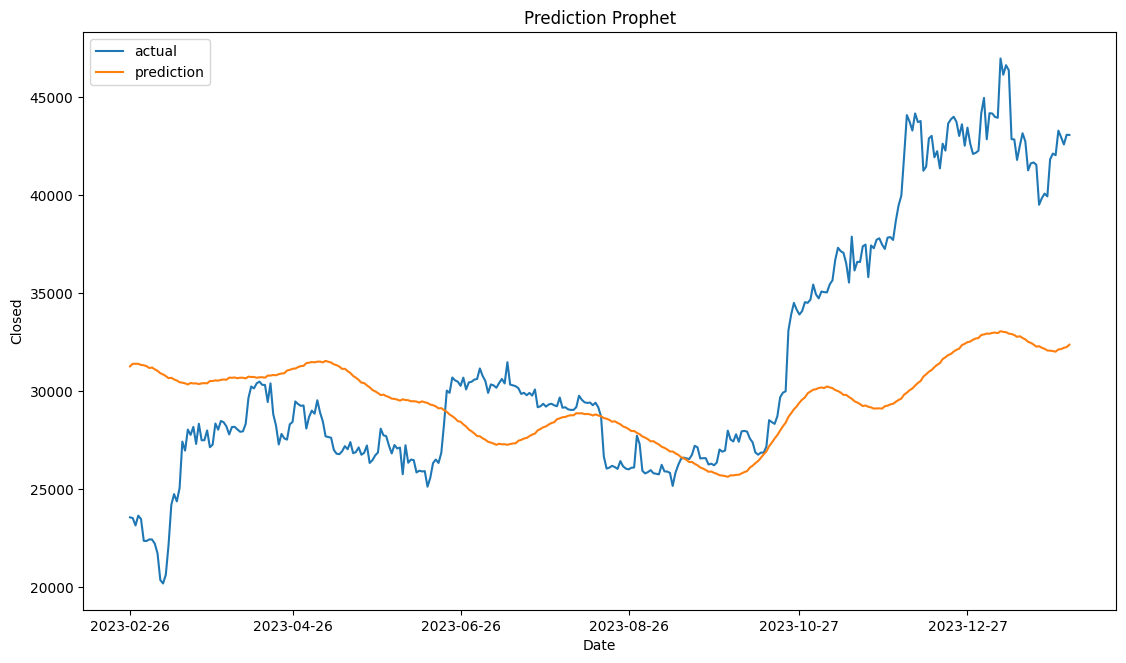

In [19]:
fig, ax = plt.subplots(1, 1, figsize=(1280 / 96, 720 / 96))
ax.plot(test['ds'], test['y'].values, label="actual")
ax.plot(test['ds'], pred, label="prediction")
ax.set_title("Prediction Prophet")
ax.set_ylabel("Closed")
ax.set_xlabel(date_column)
ax.legend()
ax.xaxis.set_major_locator(mdates.AutoDateLocator())
plt.show()